In [3]:
import os, json, cv2, numpy as np, matplotlib.pyplot as plt, yaml
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
import albumentations as A # Library for augmentations
from albumentations.pytorch import ToTensorV2
import pandas as pd
from PIL import Image
import torch.optim as optim
from torchvision import datasets, models, transforms
import torch.nn as nn
# from torchvision.transforms.functional import Interpolate
import torch.nn.functional as Func
from datetime import datetime


In [2]:
class_config_path = '../config/onehot_class_sample.yaml'
with open(class_config_path, 'r') as file:
            classes = yaml.safe_load(file)
            
valid_transform = A.Compose([
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
])

def train_transform():
    return A.Compose([
        A.Sequential([
            # A.RandomCrop(width=640, height=480),
            A.Resize(width=84, height=84),
            A.RandomRotate90(p=1),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, brightness_by_max=True, always_apply=False, p=1), # Random change of brightness & contrast
        ], p=1),
    ],
    keypoint_params=A.KeypointParams(format='xy', label_fields=['class_labels'])
    # bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']) # Bboxes should have labels, read more at https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    )

def normalize_bboxes(bboxes, width, height):
    normalized_bboxes = []
    normalized_bboxes.append([x_min/width, y_min/height, x_max/width, y_max/height] for x_min, y_min, x_max, y_max in bboxes)
    print('normalized = ', list(normalized_bboxes))   
    return normalized_bboxes

def label_transform(labels): #One-hot encoding
    target = np.zeros(len(classes), dtype=int)
    for label in labels:
        if label in classes:
            index = classes[label]
            target[index] = 1
    return target

def normalize_keypoints(keypoints, width, height):
    normalized_keypoints = []
    for x, y in keypoints:
        normalized_keypoints.append([x/width, y/height])
    return normalized_keypoints

def denormalize_keypoints(keypoints, width, height):
    denormalized_keypoints = []
    for x, y in keypoints:
        denormalized_keypoints.append([x*width, y*height])
    return denormalized_keypoints

def dk(keypoints, width, height):
    denormalized_keypoints = []
    # for x, y in keypoints:
    denormalized_keypoints.append([keypoints[0]*width, keypoints[1]*height])
    return denormalized_keypoints

In [3]:
class DownsampleCNN(nn.Module):
    def __init__(self):
        super(DownsampleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv_final = nn.Conv2d(64, 3, kernel_size=1)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((84, 84))

    def forward(self, x):
        x = Func.relu(self.conv1(x))
        x = self.pool(Func.relu(self.conv2(x)))
        x = self.pool(Func.relu(self.conv3(x)))
        x = self.conv_final(x)
        x = self.adaptive_pool(x)
        return x
    
class ResNet50Modified(nn.Module):
    def __init__(self):
        super(ResNet50Modified, self).__init__()
        resnet50 = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(resnet50.children())[:-2])
        self.conv_final = nn.Conv2d(2048, 3, kernel_size=1)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((84, 84))

    def forward(self, x):
        x = self.features(x)
        x = self.conv_final(x)
        x = self.adaptive_pool(x)
        x = x.squeeze(0)
        return x

In [4]:
class ClassDataset(Dataset):
    def __init__(self, dataset_folder, transform=None, label_transform=None, normalize_keypoints=None, demo=False):
        self.dataset_folder = dataset_folder
        self.transform = transform
        self.label_transform = label_transform
        self.demo = demo
        self.imgs_files = self.load_data(dataset_folder)
        self.downsample_cnn = ResNet50Modified()
        self.normalize_keypoints = normalize_keypoints

    def load_data(self, dataset_folder):
        images_path = os.path.join(self.dataset_folder,"images/")
        annotations_path = os.path.join(self.dataset_folder,"annotations/")
        j_data = []
        for file in os.listdir(images_path):
            if file.endswith(".jpg"):
                json_path = os.path.join(annotations_path, file.split('.')[0] + '.json')
                with open(json_path) as f:
                    json_load = json.load(f)
                    for item in json_load['shapes']:
                        points = [value for row in item['points'] for value in row]
                        j_data.append({'image':  os.path.join(images_path,file),
                                     'label': item['label'],
                                     'points':points })
        json_data = pd.DataFrame(j_data)
        return json_data

    def get_keypoint(self, bboxes):
        centers = []
        for bbox in bboxes:
            center_x = (bbox[0] + bbox[2]) / 2
            center_y = (bbox[1] + bbox[3]) / 2
            centers.append((center_x, center_y))
        return centers
    
    def __len__(self):
        return len(self.imgs_files)

    def __getitem__(self, idx):
        target = {}
        img_path, label, bboxes_original = self.imgs_files.iloc[idx]
        label = [label]
        bboxes_original = [bboxes_original]
        keypoint_original = self.get_keypoint(bboxes_original)
        img_original = cv2.imread(img_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

        if self.transform:
            # transformed = self.transform(image=img_original, bboxes=bboxes_original, class_labels=label)
            transformed = self.transform(image=img_original, keypoints=keypoint_original, class_labels=label)
            img = transformed['image']
            # bboxes = transformed['bboxes']
            # bboxes = normalize_bboxes(bboxes, img.shape[0], img.shape[1])
            keypoints = transformed['keypoints']
            label = self.label_transform(label)
        
        else:
            # img, bboxes = img_original, bboxes_original
            img, keypoints = img_original, keypoint_original

        norm_keys = self.normalize_keypoints(keypoints, img.shape[0], img.shape[1])
        target["keypoints"] = torch.as_tensor(norm_keys, dtype=torch.float32)
        target["labels"] = torch.as_tensor(label, dtype=torch.int64)
        labels = torch.as_tensor(label, dtype=torch.int64)
        encoded_label = torch.as_tensor(target["labels"], dtype=torch.int64)

        img = F.to_tensor(img)
        # resized_img = self.downsample_cnn(img.unsqueeze(0)) #Resizing using RESNET pre-trained model

        label_reshaped = encoded_label.view(1, 1, 4).repeat(1, 84, 21)
        label_reshaped = label_reshaped[:, :, :84]

        concatenated_input = torch.cat((img, label_reshaped), dim=0)

        return img, target, concatenated_input, labels
    

In [5]:
def collate_fn(batch):
    return tuple(zip(*batch))

KEYPOINTS_FOLDER_TRAIN = '../dataset/robocup_test_dataset/'
train_path = os.path.join(KEYPOINTS_FOLDER_TRAIN,"train/") #self.dataset_folder
val_path = os.path.join(KEYPOINTS_FOLDER_TRAIN,"val/")

train_dataset = ClassDataset(train_path, transform=train_transform(),label_transform=label_transform, normalize_keypoints=normalize_keypoints, demo=True)
valid_dataset = ClassDataset(val_path, transform=train_transform(),label_transform=label_transform,normalize_keypoints=normalize_keypoints, demo=True)

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=5, shuffle=True, collate_fn=collate_fn)

# dataset = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(),label_transform=label_transform, demo=True)
# data_loader = DataLoader(dataset, batch_size=5, shuffle=True, collate_fn=collate_fn)

/home/gchenc2s/anaconda3/envs/rnd/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gchenc2s/anaconda3/envs/rnd/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# encoded label is an array of [0 1 0 0] and image shape is torch.Size([3, 224, 224])
# so reshape the encoded label to torch.Size([1, 224, 224])

# have a method to fuse the encoded label and the image into a single tensor
# so the output of the method should be torch.Size([4, 224, 224])

iterator = iter(valid_loader)
images, targets, concat_vec, labels  = next(iterator)
image_number = 0
keypoints = denormalize_keypoints(targets[image_number]['keypoints'], concat_vec[image_number].shape[1], concat_vec[image_number].shape[2])

print("concatenated input size = ", concat_vec[image_number].shape)
print(f"keypoint = {targets[image_number]['keypoints']}\nlabel = {targets[image_number]['labels']}")
print ('denormalized keypoint = ',[[int(t.item()) for t in sublist] for sublist in keypoints])


concatenated input size =  torch.Size([4, 84, 84])
keypoint = tensor([[0.5662, 0.5773]])
label = tensor([0, 1, 0, 0])
denormalized keypoint =  [[47, 48]]


In [7]:
class RnDLossFunction(nn.Module):
    def __init__(self):
        super(RnDLossFunction, self).__init__()
        self.classification_loss = nn.CrossEntropyLoss()
        self.localization_loss = nn.SmoothL1Loss()

    def forward(self, preds, class_targets, bbox_targets):
        class_preds, bbox_preds = preds
        class_loss = self.classification_loss(class_preds, class_targets)
        bbox_loss = self.localization_loss(bbox_preds, bbox_targets)
        return class_loss + bbox_loss
    



In [8]:
def LaplaceNLLLoss(input, target, scale, eps=1e-06, reduction='mean'):
    loss = torch.log(2*scale) + torch.abs(input - target)/scale

    # Inputs and targets much have same shape
    input = input.view(input.size(0), -1)
    target = target.view(target.size(0), -1)
    if input.size() != target.size():
        raise ValueError("input and target must have same size")

    # Second dim of scale must match that of input or be equal to 1
    scale = scale.view(input.size(0), -1)
    if scale.size(1) != input.size(1) and scale.size(1) != 1:
        raise ValueError("scale is of incorrect size")

    # Check validity of reduction mode
    if reduction != 'none' and reduction != 'mean' and reduction != 'sum':
        raise ValueError(reduction + " is not valid")

    # Entries of var must be non-negative
    if torch.any(scale < 0):
        raise ValueError("scale has negative entry/entries")

    # Clamp for stability
    scale = scale.clone()
    with torch.no_grad():
        scale.clamp_(min=eps)

    # Calculate loss (without constant)
    loss = (torch.log(2*scale) + torch.abs(input - target) / scale).view(input.size(0), -1).sum(dim=1)


    # Apply reduction
    if reduction == 'mean':
        return loss.mean()
    elif reduction == 'sum':
        return loss.sum()
    else:
        return loss
    


def CauchyNLLLoss(input, target, scale, eps=1e-06, reduction='mean'):

    # Inputs and targets much have same shape
    input = input.view(input.size(0), -1)
    target = target.view(target.size(0), -1)
    if input.size() != target.size():
        raise ValueError("input and target must have same size")

    # Second dim of scale must match that of input or be equal to 1
    scale = scale.view(input.size(0), -1)
    if scale.size(1) != input.size(1) and scale.size(1) != 1:
        raise ValueError("scale is of incorrect size")

    # Check validity of reduction mode
    if reduction != 'none' and reduction != 'mean' and reduction != 'sum':
        raise ValueError(reduction + " is not valid")

    # Entries of var must be non-negative
    if torch.any(scale < 0):
        raise ValueError("scale has negative entry/entries")

    # Clamp for stability
    scale = scale.clone()
    with torch.no_grad():
        scale.clamp_(min=eps)

    # Calculate loss (without constant)
    loss = (torch.log(3.14*scale) + 
            torch.log(1 + ((input - target)**2)/scale**2)) .view(input.size(0), -1).sum(dim=1)


    # Apply reduction
    if reduction == 'mean':
        return loss.mean()
    elif reduction == 'sum':
        return loss.sum()
    else:
        return loss
    

class EvidentialLoss(torch.nn.Module):
    def __init__(self, mu, alpha, beta, lamda, targets, weight=None, size_average=True):
        super(EvidentialLoss, self).__init__()
        self.mu = mu
        self.alpha = alpha
        self.beta = beta
        self.lamda = lamda
        self.targets = targets

    def forward(self,  mu, alpha, beta, lamda, targets,smooth=1):
        targets = targets.view(-1)
        y = self.mu.view(-1) #first column is mu,delta, predicted value
        loga = self.alpha.view(-1) #alpha
        logb = self.beta.view(-1) #beta
        logl = self.lamda.view(-1) #lamda

        a = torch.exp(loga)
        b = torch.exp(logb)
        l = torch.exp(logl)


        term1 = (torch.exp(torch.lgamma(a - 0.5)))/(4 * torch.exp(torch.lgamma(a)) * l * torch.sqrt(b))

        term2 = 2 * b *(1 + l) + (2*a - 1)*l*(y - targets)**2


        J = term1 * term2
 
        Kl_divergence = torch.abs(y - targets) * (2*a + l)
  

        loss = J + Kl_divergence

 
        return loss.mean()
    
def GeneralGaussianNLLLoss(input, target, alpha, beta, eps=1e-06, reduction='none'): 
  
  # Inputs and targets much have same shape
  input = input.view(input.size(0), -1)
  target = target.view(target.size(0), -1)
  if input.size() != target.size():
      raise ValueError("input and target must have same size")

  # Second dim of scale must match that of input or be equal to 1
  alpha = alpha.view(input.size(0), -1)
  if alpha.size(1) != input.size(1) and alpha.size(1) != 1:
      raise ValueError("alpha is of incorrect size")

# Second dim of scale must match that of input or be equal to 1
  beta = beta.view(input.size(0), -1)
  if beta.size(1) != beta.size(1) and beta.size(1) != 1:
      raise ValueError("beta is of incorrect size")


  # Check validity of reduction mode
  if reduction != 'none' and reduction != 'mean' and reduction != 'sum':
      raise ValueError(reduction + " is not valid")

  # Entries of var must be non-negative
  if torch.any(alpha < 0):
      raise ValueError("alpha has negative entry/entries")
  # Entries of var must be non-negative
  if torch.any(beta < 0):
      raise ValueError("beta has negative entry/entries")

  # Clamp for stability
  alpha = alpha.clone()
  beta = beta.clone()
  with torch.no_grad():
      alpha.clamp_(min=eps)
      beta.clamp_(min=eps)

  # Calculate loss (without constant)
  #loss = (torch.log(2*scale) + torch.abs(input - target) / scale).view(input.size(0), -1).sum(dim=1)
  loss = (torch.abs(input - target)/alpha)**beta - torch.log(beta) + torch.log(2 * alpha ) + torch.lgamma(1/beta)


  # Apply reduction
  if reduction == 'mean':
      return loss.mean()
  elif reduction == 'sum':
      return loss.sum()
  else:
      return loss

In [9]:
# class CustomResNet50(nn.Module):
#     def __init__(self, num_classes=20, num_keypoints=1): 
#         super(CustomResNet50, self).__init__()
        
#         self.num_keypoints = num_keypoints
#         self.resnet50 = models.resnet50(pretrained=True)
#         self.resnet50.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         self.fc_cls = nn.Linear(self.resnet50.fc.in_features, num_classes)
#         self.fc_kpts = nn.Linear(self.resnet50.fc.in_features, self.num_keypoints * 2)
#         self.resnet50.fc = nn.Identity()
        
#     def forward(self, x):
#         features = self.resnet50(x)
#         class_outputs = self.fc_cls(features)
#         keypoint_outputs = self.fc_kpts(features)
#         return class_outputs, keypoint_outputs.reshape(-1, self.num_keypoints, 2)

class CustomResNet50(nn.Module):
    def __init__(self, num_classes=20, num_keypoints=1): 
        super(CustomResNet50, self).__init__()
        self.num_keypoints = num_keypoints
        self.resnet50 = models.resnet50(pretrained=True)
        # Adjust first conv layer if input channels != 3 (RGB images)
        self.resnet50.conv1 = nn.Conv2d(4, 64, kernel_size=2, stride=1, padding=3, bias=False)
        self.fc_cls = nn.Linear(self.resnet50.fc.in_features, num_classes)
        self.fc_kpts = nn.Linear(self.resnet50.fc.in_features, num_keypoints * 2)
        self.resnet50.fc = nn.Identity()
        
    def forward(self, x):
        features = self.resnet50(x)
        class_outputs = self.fc_cls(features)
        keypoint_outputs = self.fc_kpts(features)
        return class_outputs, keypoint_outputs.reshape(-1, self.num_keypoints, 2)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(model, criterion_cls, criterion_kpt, optimizer, train_loader, valid_loader, num_epochs=25):
    train_losses = []
    valid_losses = []
    key_train_losses = []
    key_valid_losses = []
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        total_kpt_loss = 0.0

        for images, targets, concat_vecs, labels in train_loader:
            labels = [label.to(device) for label in labels]
            concat_vecs = torch.stack(concat_vecs).to(device)
            ground_truth_keypoints = torch.stack([target['keypoints'].to(device) for target in targets])

            labels_tensor = torch.stack(labels)
            class_indices = torch.argmax(labels_tensor, dim=1)

            optimizer.zero_grad()

            class_outputs, keypoint_outputs = model(concat_vecs)
            
            loss_cls = criterion_cls(class_outputs, class_indices)
            loss_kpt = criterion_kpt(keypoint_outputs, ground_truth_keypoints)
            total_loss = loss_cls + loss_kpt  # Combine losses for backpropagation

            total_loss.backward()
            optimizer.step()

            total_train_loss += loss_cls.item() * concat_vecs.size(0)
            total_kpt_loss += loss_kpt.item() * concat_vecs.size(0)

        avg_train_loss = total_train_loss / len(train_loader.dataset)
        avg_kpt_loss = total_kpt_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Keypoint Loss: {avg_kpt_loss:.4f}')

        model.eval()
        total_val_loss = 0.0
        total_val_kpt_loss = 0.0

        with torch.no_grad():
            for images, targets, concat_vecs, labels in valid_loader:
                labels = [label.to(device) for label in labels]
                concat_vecs = torch.stack(concat_vecs).to(device)
                ground_truth_keypoints = torch.stack([target['keypoints'].to(device) for target in targets])

                labels_tensor = torch.stack(labels)
                class_indices = torch.argmax(labels_tensor, dim=1)

                class_outputs, keypoint_outputs = model(concat_vecs)
                
                loss_cls = criterion_cls(class_outputs, class_indices)
                loss_kpt = criterion_kpt(keypoint_outputs, ground_truth_keypoints)
                
                total_val_loss += loss_cls.item() * concat_vecs.size(0)
                total_val_kpt_loss += loss_kpt.item() * concat_vecs.size(0)

        avg_val_loss = total_val_loss / len(valid_loader.dataset)
        avg_val_kpt_loss = total_val_kpt_loss / len(valid_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}, Keypoint Loss: {avg_val_kpt_loss:.4f}')
        train_losses.append(avg_train_loss)
        valid_losses.append(avg_val_loss)
        key_train_losses.append(avg_kpt_loss)
        key_valid_losses.append(avg_val_kpt_loss)

    return model, train_losses, key_train_losses, valid_losses, key_valid_losses  # Optionally return the model

In [11]:
model = CustomResNet50(num_classes=4, num_keypoints=1)
criterion_cls = nn.CrossEntropyLoss()
criterion_kpt = nn.MSELoss()
# criterion_kpt = LaplaceNLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
# train_losses, valid_losses = train_model(model, criterion, criterion_kpt, optimizer, train_loader, valid_loader, num_epochs=80)
trained_model, train_loss, key_train_loss, val_loss, key_val_loss = train_model(model, criterion_cls, criterion_kpt, optimizer, train_loader, valid_loader, num_epochs=50)
# train_model(model, criterion, optimizer, num_epochs)
torch.save(model.state_dict(), '../models/resnet50_trained_12.pth')

Epoch 1/50, Training Loss: 0.5130, Keypoint Loss: 0.1265
Epoch 1/50, Validation Loss: 0.2166, Keypoint Loss: 0.2849
Epoch 2/50, Training Loss: 0.5538, Keypoint Loss: 0.0959
Epoch 2/50, Validation Loss: 0.0091, Keypoint Loss: 0.3280
Epoch 3/50, Training Loss: 0.6440, Keypoint Loss: 0.1317
Epoch 3/50, Validation Loss: 0.1153, Keypoint Loss: 0.1735
Epoch 4/50, Training Loss: 0.3044, Keypoint Loss: 0.1310
Epoch 4/50, Validation Loss: 0.0209, Keypoint Loss: 0.0645
Epoch 5/50, Training Loss: 0.2056, Keypoint Loss: 0.0892
Epoch 5/50, Validation Loss: 0.3388, Keypoint Loss: 0.1874
Epoch 6/50, Training Loss: 0.2540, Keypoint Loss: 0.0841
Epoch 6/50, Validation Loss: 0.0464, Keypoint Loss: 0.3503
Epoch 7/50, Training Loss: 0.2053, Keypoint Loss: 0.0991
Epoch 7/50, Validation Loss: 0.0071, Keypoint Loss: 0.1212
Epoch 8/50, Training Loss: 0.2354, Keypoint Loss: 0.0831
Epoch 8/50, Validation Loss: 0.0372, Keypoint Loss: 0.0436
Epoch 9/50, Training Loss: 0.1385, Keypoint Loss: 0.0894
Epoch 9/50, Val

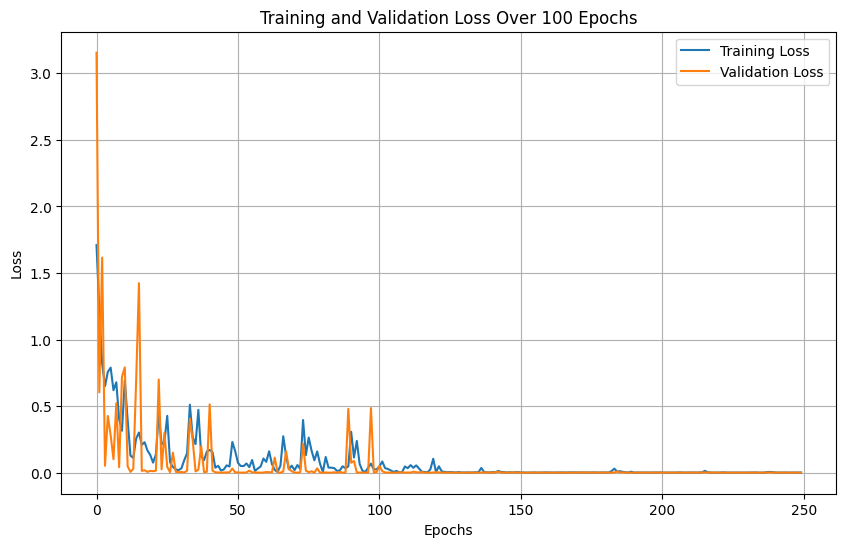

In [12]:
def plot_losses(train_losses, valid_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.title('Training and Validation Loss Over 100 Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(train_loss, val_loss)

In [31]:
num_classes = 4 
model = CustomResNet50(num_classes=num_classes, num_keypoints=1)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device = ', device)
model.to(device)

# criterion = RnDLossFunction() 
criterion = nn.CrossEntropyLoss()
criterion_kpt = torch.nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
temp = None


device =  cpu


In [12]:
def train_model(model, criterion, criterion_kpt, optimizer, train_loader, valid_loader, num_epochs=25):
    train_losses = []
    valid_losses = []
    alpha = torch.full((5, 2), 0.1)  # Moderate confidence
    beta = torch.full((5, 2), 2.0)

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        total_kpt_loss = 0.0

        for images, targets, concat_vecs, labels in train_loader:
            
            labels = [label.to(device) for label in labels]
            concat_vecs = torch.stack(concat_vecs).to(device)
            ground_truth_keypoints = torch.stack([target['keypoints'].to(device) for target in targets])

            optimizer.zero_grad()
            
            class_outputs, keypoint_outputs = model(concat_vecs)
            labels_tensor = torch.stack(labels)
            class_indices = torch.argmax(labels_tensor, dim=1)
            ls = torch.argmax(class_outputs, dim=1)
            print('ls = ', ls)
            print('class_outputs = ', class_outputs)
            print('class_indices = ', class_indices)
            print('labels = ', labels)
            print('keypoint_outputs = ', keypoint_outputs)
            print('ground_truth_keypoints = ', ground_truth_keypoints)

            # optimizer_kpt = optim.SGD([keypoint_outputs], lr=0.01)  # Replace [keypoints_outputs] with model.parameters() if keypoints_outputs are model outputs
            # optimizer_kpt.zero_grad()

            loss = criterion(class_outputs, class_indices)
            # loss_kpt = GeneralGaussianNLLLoss(keypoint_outputs, ground_truth_keypoints, alpha=alpha, beta=beta, eps=1e-06, reduction='mean')
            loss_kpt = criterion_kpt(keypoint_outputs, ground_truth_keypoints)
            loss.backward()
            loss_kpt.backward()
            optimizer.step()
            # optimizer_kpt.step()
            total_train_loss += loss.item() * concat_vecs.size(0)
            total_kpt_loss += loss_kpt.item() * concat_vecs.size(0)
        
        train_epoch_loss = total_train_loss / len(train_loader.dataset)
        train_kpt_loss = total_kpt_loss / len(valid_loader.dataset)

        train_losses.append(train_epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_epoch_loss}, Train Keypoint Loss: {train_kpt_loss}')
        

        model.eval()
        total_val_loss = 0.0
        total_kpt_loss_val = 0.0

        with torch.no_grad():
            for images, targets, concat_vecs, labels in valid_loader:
                concat_vecs = torch.stack(concat_vecs).to(device)
                labels = torch.stack([label.to(device) for label in labels])
                ground_truth_keypoints_val = torch.stack([target['keypoints'].to(device) for target in targets])

                class_outputs, keypoint_outputs = model(concat_vecs)
                labels_tuple = tuple(labels[i] for i in range(labels.size(0)))
                labels_tensor = torch.stack(labels_tuple)
                class_indices = torch.argmax(labels_tensor, dim=1)
                
                loss = criterion(class_outputs, class_indices)  
                loss_kpt_val = GeneralGaussianNLLLoss(keypoint_outputs, ground_truth_keypoints_val,alpha=alpha, beta=beta, eps=1e-06, reduction='mean')

                total_val_loss += loss.item() * concat_vecs.size(0)
                total_kpt_loss_val += loss_kpt_val.item() * concat_vecs.size(0)

        avg_valid_loss = total_val_loss / len(valid_loader.dataset)
        val_kpt_loss = total_kpt_loss_val / len(valid_loader.dataset)
        valid_losses.append(avg_valid_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_valid_loss}, Val Keypoint Loss: {val_kpt_loss}')
    
    return train_losses, valid_losses




In [28]:
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

train_losses, valid_losses = train_model(model, criterion, criterion_kpt, optimizer, train_loader, valid_loader, num_epochs=80)
# train_model(model, criterion, optimizer, num_epochs)
torch.save(model.state_dict(), '../models/resnet50_trained_11.pth')

NameError: name 'criterion' is not defined

In [ ]:
def plot_losses(train_losses, valid_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.title('Training and Validation Loss Over 100 Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(train_losses, valid_losses)

In [32]:
model.load_state_dict(torch.load('../models/resnet50_trained_11.pth'))
model.eval()

def val_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs=25):
    valid_losses = []
    total_val_loss = 0.0
    image = []
    keypoint = []

    with torch.no_grad():
        for images, targets, concat_vecs, labels in valid_loader:
            concat_vecs = torch.stack(concat_vecs).to(device)
            labels = torch.stack([label.to(device) for label in labels])
            ground_truth_keypoints_val = torch.stack([target['keypoints'].to(device) for target in targets])

            print('ground_truth_keypoints_val = ', ground_truth_keypoints_val)
            class_outputs, keypoint_outputs = model(concat_vecs)
            _, predicted = torch.max(class_outputs, 1)
            print('targets = ', targets[0]['keypoints'])
            # print('class_outputs = ', class_outputs)
            print('predicted = ', predicted)
            print('keypoint_outputs = ', keypoint_outputs)
            print('labels = ', labels)
            labels_tuple = tuple(labels[i] for i in range(labels.size(0)))
            labels_tensor = torch.stack(labels_tuple)
            class_indices = torch.argmax(labels_tensor, dim=1)
            
            image.append(images)
            keypoint.append(keypoint_outputs)
            loss = criterion(class_outputs, class_indices)
            total_val_loss += loss.item() * concat_vecs.size(0)
            
    avg_valid_loss = total_val_loss / len(valid_loader.dataset)
    
    valid_losses.append(avg_valid_loss)
    return image, keypoint


In [33]:
images_val, keypoints_val = val_model(model, criterion_cls, optimizer, train_loader, valid_loader, num_epochs=75)
print('images_val = ', images_val[0][0].shape)
# val_accuracy = val_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs=75)


ground_truth_keypoints_val =  tensor([[[0.5058, 0.3922]],

        [[0.3589, 0.4109]],

        [[0.5912, 0.5273]],

        [[0.3959, 0.5641]],

        [[0.4798, 0.3625]]])
targets =  tensor([[0.5058, 0.3922]])
predicted =  tensor([3, 3, 1, 1, 3])
keypoint_outputs =  tensor([[[0.2148, 0.3840]],

        [[0.4962, 0.1903]],

        [[0.4338, 0.4859]],

        [[0.6171, 0.5250]],

        [[0.3288, 0.3321]]])
labels =  tensor([[0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 1, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1]])
ground_truth_keypoints_val =  tensor([[[0.4398, 0.6000]],

        [[0.5889, 0.6068]],

        [[0.4656, 0.6479]],

        [[0.6701, 0.4808]],

        [[0.5266, 0.5542]]])
targets =  tensor([[0.4398, 0.6000]])
predicted =  tensor([3, 2, 3, 3, 1])
keypoint_outputs =  tensor([[[0.6311, 0.2325]],

        [[0.6313, 0.3232]],

        [[0.6038, 0.2013]],

        [[0.5547, 0.2437]],

        [[0.6029, 0.7576]]])
labels =  tensor([[0, 0, 0, 1],
        [0, 0, 1,

[[0.21484862 0.3840124 ]
 [0.4962482  0.19033155]
 [0.43382215 0.4859101 ]
 [0.6171342  0.5249738 ]
 [0.32880753 0.3320511 ]]
[0.21484862 0.3840124 ]
tensor([102.0473, 116.2570])
model key [18.047285 32.257042]
(84, 84, 3)


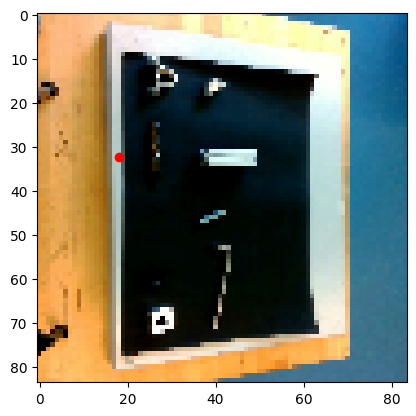

In [39]:
img_size = 84
kp = keypoints_val[0].reshape(-1, 2)
print(np.array(kp))
print(np.array(kp[0]))

denormalized_keypoints = ((kp[0] + 1) * img_size)
# denormalized_keypoints = [52, 40]
print(denormalized_keypoints)

dky = np.array(dk(kp[0],84,84))
print("model key",dky[0])
pic = (images_val[0][0].permute(1,2,0).detach().numpy() * 255).astype(np.uint8)
print(pic.shape)
fig, ax = plt.subplots()
# dky = [0.5058, 0.3840]
ax.imshow(pic)

# ax.plot(denormalized_keypoints[0], denormalized_keypoints[1], 'ro') 
ax.plot(dky[0][0], dky[0][1], 'ro')
# ax.plot(0.5058, 0.3840, 'bo')

plt.show()


In [ ]:
model.load_state_dict(torch.load('../models/resnet50_trained_3.pth'))
model.eval()

# Function to evaluate the model on validation and test sets
def evaluate_model(model, data_loader):
    correct = total = 0
    with torch.no_grad():
        for inputs, targets, concat_vecs, labels in data_loader:
            concat_vecs, labels = torch.stack(concat_vecs).to(device), [label.to(device) for label in labels]
            outputs = model(concat_vecs)
            _, predicted = torch.max(outputs, 1)
            print(np.array(labels).shape[0])
            total += np.array(labels).shape[0]
            correct_pred = (predicted == labels)
            print(predicted)
            total_correct = correct_pred.sum().item()
            correct += total_correct
    return 100 * correct / total

In [ ]:
val_accuracy = evaluate_model(model, valid_loader)
# test_accuracy = evaluate_model(model, test_loader)

print(f'Validation Accuracy: {val_accuracy:.2f}%')

In [ ]:
def visualize(image, bboxes, image_original=None, bboxes_original=None):
    fontsize = 18

    for bbox in bboxes:
        # for keypoints
        keypoint = (bbox[0], bbox[1])
        image = cv2.circle(image.copy(), keypoint, 1, (0,255,0), 2)
        # for bbox
        # start_point, end_point = (bbox[0], bbox[1]), (bbox[2], bbox[3])
        # image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)


    if image_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)

    else:
        for bbox in bboxes_original:
            # for keypoints
            keypoint = (bbox[0], bbox[1])
            image_original = cv2.circle(image_original.copy(), keypoint, 1, (0,255,0), 2)
            # for bbox
            # start_point, end_point = (bbox[0], bbox[1]), (bbox[2], bbox[3])
            # image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)


        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)

image1 = (img[image_number].permute(1,2,0).detach().numpy() * 255).astype(np.uint8)
image = (images[image_number].permute(1,2,0).detach().numpy() * 255).astype(np.uint8)

print('labels',labels[image_number]['keypoints'])

# keypoints = labels[image_number]['keypoints'].detach().cpu().numpy().astype(np.float32).tolist()
keypoints = labels[image_number]['keypoints']
keypo = keyp[image_number].detach().cpu().numpy().astype(np.int32).tolist()

print ('keypoints',keypoints)
print ('image shape',image.shape)

keypoints = denormalize_keypoints(keypoints, image.shape[0], image.shape[1])
print ('denormalized',keypoints)
kp = [[int(t.item()) for t in sublist] for sublist in keypoints]
print ('kp',kp)

# visualize(image, bboxes, image, bboxes)
visualize(image, kp, image, kp)
print(keypo)
visualize(image1, keypo, image1, keypo)